In [220]:
import pandas as pd
import numpy as np
import datetime
import imp
import scripts as scr
import os
import re
import multiprocessing
import numpy as np
import pandas as pd
from pytictoc import TicToc
from IPython.display import display
import itertools
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
# import datetime


def transform_cols (df, dict_col_types = None):
    # Расширяйте для необходимых столбцов и их явной типизации
    if dict_col_types is None:
        dict_col_types = {
        'amount_original':(float, 0.0),
        'channel_indicator_desc':(str, u'null'),
        'event_description':(str, u'null'),
        'short_date':(int, 0),
        'cdf_s_20':(str, u'null'),
        'cdf_s_126':(str, u'null'),
        'cdf_s_127':(int, 30),
        'cdf_s_129':(int, 30),
        'cdf_s_138':(str, u'null'),
        'cdf_s_130':(int, 30),
        'cdf_s_133':(int, 30),
        'cdf_s_134':(int, 30),
        'cdf_s_135':(int, 30),
        'cdf_s_140':(float, 0.0),
        'cdf_s_218':(str, u'null'),
        'cdf_s_294':(int, 0),
        'cdf_s_299':(str, u'null'),
        'data_s_65':(int, 0),
        'data_i_120':(int, 0),
        'data_i_154':(float, -150)
        }
                
    if df.shape[0] == 0:
        return df
    
    df.replace(u'null', np.nan, inplace=True)

    for i in dict_col_types:
        if i in df.columns:
            change_type, fill_value = dict_col_types[i]
            df[i] = df[i].fillna(fill_value).astype(change_type)
    
    return df

def calc_base_features(data):
    feat_matrix = pd.DataFrame()
    #data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    
    if data.shape[0] == 0:
        return feat_matrix
    
    # заполняем ряд пропусков

    # кумулятивная сумма опреаций за сутки, если не заполнена, то значит это первая операций, т.е. = 0
    data.cdf_s_140 = data.cdf_s_140.fillna(0).astype(float)/1000
    data.data_i_120.fillna(1, inplace=True)

    
    feat_matrix['event_id'] = data.event_id
    feat_matrix['user_id'] = data.user_id
    feat_matrix['custom_mark'] = data.custom_mark    
    feat_matrix['event_time'] = data.event_time
    feat_matrix['amount'] = data.amount_original

    feat_matrix['data_i_120'] = data.data_i_120
    cdf_keep_cols = ['cdf_s_127', 'cdf_s_129', 'cdf_s_130', 'cdf_s_133', 'cdf_s_134', 'cdf_s_135']
    feat_matrix.loc[:, cdf_keep_cols] = data[cdf_keep_cols]
    feat_matrix['data_i_120'] = data.data_i_120

    # кумулятивная сумма операций за сутки в каналах web и МП
    feat_matrix['cumulative_sum_total'] = data.cdf_s_140

    
    feat_matrix['client_age'] = [x.days/360 for x in (data.event_time - data.cdf_s_19)]
  
        
    feat_matrix['cat_new_ip'] = [1 if x == u'ДА' else 0 if x == u'НЕТ' else 2 for x in data.cdf_s_126]
    feat_matrix['cat_new_prov'] =  [1 if x == u'ДА' else 0 if x == u'НЕТ' else 2 for x in data.cdf_s_138]
    feat_matrix['channel_op'] =  [0 if x == u'MOBILE' else 1 if x == u'WEB' else 2 for x in data.channel_indicator_desc]
    feat_matrix['op_type'] = [0 if x == u'Перевод частному лицу' else 1 if x==u'Оплата услуг' else 2 if x ==u'Перевод между своими счетами и картами' else 3 for x in data.event_description]


    # бинарный флаг определяющий наличие возраста получателя
    # (полезен для линейных моделей,  менее для деревьев с учетом следующего признака)
    feat_matrix['recip_age'] = [1 if x == 0 else 0 for x in data.cdf_s_294]
    # разница возорастов получателей и отправителей, если отсутствует/неприменимо, то padding 500
    feat_matrix['age_diff'] = feat_matrix.client_age - [int(x) if x != 0 else 1000 for x in data.cdf_s_294]
    
    feat_matrix['relative'] = [1 if x == u'ДА' else 0 for x in data.cdf_s_218] # перевод родственнику
    
    feat_matrix['know_recip_power'] = [ x if x is not None else 0 for x in data.data_s_65] # сила связи отправителя и получателя
    

    feat_matrix['data_i_154'] = [ x if x is not None else -150 for x in data.data_i_154]
    feat_matrix['know_recip_card_age'] = [1 if x is not None else 0 for x in data.cdf_s_124]
    
    
    feat_matrix['recip_card_age'] = [x.days if type(x) is not pd.tslib.NaTType else 912321 for x in (data.event_time - data.cdf_s_124)]
    
    # feat_matrix['cat_client_region'] = [x if x.isdigit() else 912321 for x in data.cdf_s_20]
    feat_matrix['one_region'] = (data.cdf_s_20 == data.cdf_s_299).astype(int) # сравнение регионов
    

    #ADD NEW FEATURES
    feat_matrix['krp_pow2'] = (feat_matrix['know_recip_power']) ** 2
    feat_matrix['log_amount'] = np.log(feat_matrix['amount'] + 1)
    feat_matrix['ip_isp'] = np.array([x if x.isdigit() else 912321 for x in data.cdf_s_20], dtype=float)
    feat_matrix['amnt2chnls'] = (data["amount_original"].fillna(0).astype(float) / \
        (data["cdf_s_136"].fillna(0).astype(float) + data["amount_original"].fillna(0).astype(float) + \
            data["amount_original"].fillna(0) + 1))
    
    # поставил order_cols временно, чтобы сохранить такой же порядок как в оригинальном
    order_cols = ['event_id', 'user_id', 'custom_mark', 'event_time', 'amount',
                  'client_age', 'cat_new_ip', 'cat_new_prov', 'channel_op', 'op_type',
                  'recip_age', 'age_diff', 'cumulative_sum_total', 'data_i_120',
                  'relative', 'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
                  'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
                  'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
                  'log_amount', 'ip_isp', 'amnt2chnls']
    feat_mat = feat_mat[order_cols].copy()
    return feat_matrix


def load_data(chunk_fnames, fields=None, query=None, sample='train', dict_col_types=None):
    df = pd.DataFrame({})
    if isinstance(chunk_fnames, str):
        chunk_fnames = [chunk_fnames]
        
    for filename in chunk_fnames:
        chunk_df = pd.read_feather(filename)
            
        if fields is None:
            fields = chunk_df.columns.tolist()
        
        transormed = transform_cols(chunk_df)
        
        if query:
            transormed = transormed.query(query)
 
        df = pd.concat([df, transormed[fields], ignore_index=True
    return df


def features_handler(chunk_names, calc_feat, query=None, chunk_size=5000):
    res_df = pd.DataFrame()
    
    for chunk_name in chunk_names:
        loaded_data = load_data(chunk_name, query=query, dict_col_types=None)
        feat_chunk = calc_feat(loaded_data)
        res_df = pd.concat([res_df, feat_chunk], ignore_index=True)

    return res_df


def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', np.NaN]:
        ret = 0
    
    return ret

In [8]:
FIRST_N = 100
N_THREADS = 16
train_folder = '../../data/raw_splits/train/'
train_files = sorted([x for x in os.listdir(train_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
train_files = [os.path.join(train_folder, x) for x in train_files]
print(f'Length of train files is {len(train_files)}')
train_files[:5]

Length of train files is 51


['../../data/raw_splits/train/chunk_0.fth',
 '../../data/raw_splits/train/chunk_1.fth',
 '../../data/raw_splits/train/chunk_2.fth',
 '../../data/raw_splits/train/chunk_3.fth',
 '../../data/raw_splits/train/chunk_4.fth']

In [27]:
%%time
data_raw = pd.read_feather(train_files[0])

CPU times: user 4.13 s, sys: 2.24 s, total: 6.36 s
Wall time: 6.6 s


In [ ]:
data.loc[data['ip_isp'] == '912321']

In [15]:
def quick_isp(fname):
    data = pd.read_feather(fname)
    return data.loc[data['ip_isp'] == '912321'].copy()
    

In [17]:
with multiprocessing.Pool(min(N_THREADS, FIRST_N)) as pool:
    isp = pool.map(quick_isp, train_files)

In [19]:
pd.concat(isp)

,cdf_s_123,cdf_s_124,cdf_s_127,cdf_s_135,cdf_s_130,cdf_s_129,cdf_s_134,cdf_s_128,cdf_s_138,cdf_s_126,...,user_acct_number_hashed,user_agent_string_hash,browser_plugins_hash,screen_hash,user_id,ip_address,ip_country,ip_region,ip_city,ip_isp


---

In [28]:
%%time
data = transform_cols(data_raw)

CPU times: user 38.6 s, sys: 8.8 s, total: 47.4 s
Wall time: 47.4 s


In [30]:
data.columns

Index(['cdf_s_123', 'cdf_s_124', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
       'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126',
       'cdf_s_133', 'cdf_s_136', 'cdf_s_137', 'cdf_s_140', 'cdf_s_178_hashed',
       'cdf_s_19', 'cdf_s_20', 'cdf_s_218', 'cdf_s_294', 'cdf_s_299',
       'amount_original', 'channel_indicator_desc', 'custom_mark',
       'data_i_118', 'data_i_119', 'data_i_120', 'data_i_154', 'data_s_65',
       'event_description', 'event_id', 'event_time', 'ext_acct_number_hashed',
       'hardwareid', 'short_date', 'user_acct_number_hashed',
       'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash',
       'user_id', 'ip_address', 'ip_country', 'ip_region', 'ip_city',
       'ip_isp'],
      dtype='object')

### Подробнее что есть что

'event_id'- уникальный id транзакции

'short_date' - дата (для удобства поиска/агрегации)

'user_id' - уникальный идентификатор клиента

'event_time' - дата и время собятия

'custom_mark'- результат разбора события

'channel_indicator_desc' - канал проведения операции (web, мобильное приложение, SMS-банк и пр.)

'event_description' - описание непосредственно события (например, вход в систему или перевод, оплата услуг)

'amount_original' - сумма в рублях

'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash' - различные признаки устройства (с определенной степенью точности позволяет понять уникальность устройства в разрезе пользователя)

ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp' - данные, связанные с IP (регион, город и интернет-провадйер по БД гео-IP)
'hardwareid' - уникальный идентификатор устройства для канала мобильных приложений

'user_acct_number_hashed'- счет отправителя (хэшированный)
'ext_acct_number_hashed'- счет получателя (хэшированный)


'data_s_65' - результат определения связи между отправителем и получателем (чем больше, тем сильнее связь) 
'data_i_118', 'data_i_119’, 'data_i_120', 'data_i_154' - ряд признаков, которые описывают устройство, с которого проводятся операции
 


 'cdf_s_136','cdf_s_137','cdf_s_140'- кумулятивные суммы операций за сутки в web, МП, web + МП
 'cdf_s_218'- предполагаемое наличие родственной связи 
 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126' - дней с момента различных рисковых событий



 'cdf_s_19'- ДР клиента
 'cdf_s_20'- Территориальный банк клиента (региональный признак)
 'cdf_s_299'- Тер банк получателя (региональный признак)

 'cdf_s_294'- возраст получателя

 'cdf_s_123'- региональный признак получателя (более локальный по сравнению с ТБ)<br>
 'cdf_s_124'- дата выдачи карты получателя

 'cdf_s_178_hashed' - реквизит получателя

In [68]:
%%time
feat_matrix['user_id_digit_only'] = feat_matrix['user_id'].apply(lambda x: x.isdigit())
user_id_what_suffix = pd.Series([re.sub('[0-9]', '', x) for x in data['user_id']])
for suffix in ['MBK', 'VSP', 'CRM', 'IVR', 'other']:
    if suffix == 'other':
        result = ~user_id_what_suffix.isin(['MBK', 'VSP', 'CRM', 'IVR', ''])
    else:
        result = (user_id_what_suffix == suffix).astype(int)
    feat_matrix[f'user_id_{suffix}'] = result

CPU times: user 4.64 s, sys: 87.9 ms, total: 4.73 s
Wall time: 4.73 s


In [97]:
feat_matrix['event_hour'] = [x.hour for x in feat_matrix['event_time']]
feat_matrix['event_hour_night'] = [1 if ((hour >= 23) or (hour <= 7)) else 0 for hour in feat_matrix['event_hour']]
feat_matrix['event_hour_workhour'] = [1 if ((hour >= 8) or (hour <= 17)) else 0 for hour in feat_matrix['event_hour']]
feat_matrix['event_hour_evening'] = [1 if ((hour >= 18) or (hour <= 22)) else 0 for hour in feat_matrix['event_hour']]

In [ ]:
feat_matrix['event_day'] = [x.dayofweek for x in feat_matrix['event_time']]
feat_matrix['event_day_is_weekend'] = [1 if day >= 6 else 0 for day in feat_matrix['event_day']]

In [109]:
data['is_fraud'] = [cust_mark_to_class(x) for x in data['custom_mark']]

In [110]:
data['is_fraud'].value_counts()

 0    1368638
 1        686
-1        291
Name: is_fraud, dtype: int64

In [111]:
fraud_users = set(data.loc[data['is_fraud'] == 1, 'user_id'])

In [112]:
fraud = data.loc[data['user_id'].isin(fraud_users)]

In [113]:
fraud.shape

(52300, 46)

In [115]:
fraud.groupby('user_id')['is_fraud'].agg(np.sum).sort_values()

user_id
18489906       -3
67460713        0
83860916        0
21263096        0
42854692        0
24514106        0
33288296        1
33440349        1
71930875        1
41448307        1
38163388        1
3911617         1
32395611        1
69471360        1
31561397        1
7410167         1
71418046        1
VSP707918       1
66439478        1
53927523        1
60246553        1
5289558         1
61274376        1
5081144         1
62193631        1
62995357        1
63049459        1
49035582        1
64366597        1
66179947        1
               ..
24595964        6
19803224        6
22030688        6
12049024        6
87986988        7
18199100        7
28179889        7
84725370        7
49699331        7
21139877        7
13997765        7
MBK10980439     8
34866101        8
32409671        8
39619880        8
23852680        9
51169350        9
20082021        9
MBK7852085     12
56534514       12
15802598       13
89644674       13
63928242       13
30773086       17
58

In [124]:
fraud.columns

Index(['cdf_s_123', 'cdf_s_124', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
       'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126',
       'cdf_s_133', 'cdf_s_136', 'cdf_s_137', 'cdf_s_140', 'cdf_s_178_hashed',
       'cdf_s_19', 'cdf_s_20', 'cdf_s_218', 'cdf_s_294', 'cdf_s_299',
       'amount_original', 'channel_indicator_desc', 'custom_mark',
       'data_i_118', 'data_i_119', 'data_i_120', 'data_i_154', 'data_s_65',
       'event_description', 'event_id', 'event_time', 'ext_acct_number_hashed',
       'hardwareid', 'short_date', 'user_acct_number_hashed',
       'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash',
       'user_id', 'ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp',
       'is_frad', 'is_fraud'],
      dtype='object')

In [140]:
#, ['user_id', 'amount_original', 'event_time']
one_fraud = fraud.loc[fraud['user_id'] == '77365411', [x for x in fraud.columns if (not x.startswith('cdf')) and (not x.startswith('data_'))]].sort_values('event_time')

In [154]:
not_fraud = data.loc[~data['user_id'].isin(fraud_users)]

In [174]:
not_fraud_mean_cities = []
for key, group in itertools.groupby(zip(not_fraud['user_id'], not_fraud['ip_city']), key = lambda x: x[0]):
    a = []
    for k, v in group:
        a.append(v)
    not_fraud_mean_cities.append(len(set(a) - set([np.nan, 'empty'])))

In [175]:
np.mean(not_fraud_mean_cities)

3.900859752821064

In [176]:
np.median(not_fraud_mean_cities)

3.0

In [181]:
fraud.groupby('user_id')['ip_city'].agg(lambda a: len(set(a) - set([np.nan, 'empty']))).mean()

3.7151162790697674

In [100]:
with pd.
data['event_description'].value_counts()

Вход в систему с одноразовым паролем                                                                     600275
Перевод частному лицу                                                                                    202202
Просмотр документа                                                                                       180245
Оплата услуг                                                                                             129055
Перевод между своими счетами и картами                                                                    84047
Вход в систему без одноразового пароля                                                                    32511
MobileOffer                                                                                               21192
mP2P                                                                                                      20001
Неуспешный вход в систему                                                                               

In [99]:
for suffix in ['MOBILEAPI', 'WEBAPI', 'ATMAPI', 'MBK', 'other']:
    if suffix == 'other':
        result = ~user_id_what_suffix.isin(['MOBILEAPI', 'WEBAPI', 'ATMAPI', 'MBK'])
    else:
        result = (user_id_what_suffix == suffix).astype(int)
    feat_matrix[f'channel_indicator_desc_is_{suffix}'] = result

In [44]:
#%%time
tt = TicToc()
tt.tic()

feat_matrix = pd.DataFrame()
#data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]

if data.shape[0] == 0:
    raise 'shape is 0'

# заполняем ряд пропусков
data.cdf_s_140 = data.cdf_s_140.fillna(0).astype(float) / 1000
data.data_i_120.fillna(1, inplace=True)

feat_matrix['amount'] = data['amount_original']
same_columns = ['event_id', 'user_id', 'custom_mark', 'event_time', 
                'cdf_s_127', 'cdf_s_129', 'cdf_s_130', 'cdf_s_133', 'cdf_s_134', 'cdf_s_135', 'data_i_120']
for column in same_columns:
    feat_matrix.loc[:, column] = data[column]

tt.toc('First')

First 2.044484 seconds.


In [197]:
data.cdf_s_19

0         1977-02-15
1         1977-02-15
2         1977-02-15
3         1977-02-15
4         1977-02-15
5         1977-02-15
6         1977-02-15
7         1977-02-15
8         1977-02-15
9         1977-02-15
10        1977-02-15
11        1977-02-15
12        1977-02-15
13        1977-02-15
14        1977-02-15
15        1977-02-15
16        1977-02-15
17        1977-02-15
18        1977-02-15
19        1977-02-15
20        1977-02-15
21        1977-02-15
22        1977-02-15
23        1977-02-15
24        1977-02-15
25        1977-02-15
26        1977-02-15
27        1977-02-15
28        1977-02-15
29        1977-02-15
             ...    
1369585   1968-02-13
1369586   1968-02-13
1369587   1968-02-13
1369588          NaT
1369589   1968-02-13
1369590   1968-02-13
1369591   1968-02-13
1369592   1968-02-13
1369593   1968-02-13
1369594   1968-02-13
1369595   1968-02-13
1369596   1968-02-13
1369597   1968-02-13
1369598          NaT
1369599   1968-02-13
1369600   1968-02-13
1369601   196

In [207]:
feat_matrix['client_age'].isnull().sum()

213058

In [208]:
data.cdf_s_126.value_counts(dropna=False)

null    981523
ДА      234106
НЕТ     153986
Name: cdf_s_126, dtype: int64

In [211]:
feat_matrix['cat_new_prov'].value_counts()

2    981523
0    373021
1     15071
Name: cat_new_prov, dtype: int64

In [212]:
data.channel_indicator_desc.value_counts(dropna=False)

MOBILEAPI     1017473
WEBAPI         132591
ATMAPI         127791
MBK             79184
CRM              8380
IVR              2503
VSP              1213
CALLCENTER        402
UFS.WEBAPI         54
INTERNET           24
Name: channel_indicator_desc, dtype: int64

In [213]:
# кумулятивная сумма операций за сутки в каналах web и МП, умножил на 1e15 из-за того, что там сильно маленькие числа
feat_matrix['cumulative_sum_total'] = data.cdf_s_140 * 1e15


feat_matrix['client_age'] = [x.days / 365.25 for x in (data.event_time - data.cdf_s_19)]
feat_matrix['client_age_isnull'] = feat_matrix['client_age'].isnull().astype(int)

#заменил на -1
feat_matrix['cat_new_ip'] = [1 if x == 'ДА' else 0 if x == 'НЕТ' else -1 for x in data.cdf_s_126]
feat_matrix['cat_new_prov'] =  [1 if x == 'ДА' else 0 if x == 'НЕТ' else -1 for x in data.cdf_s_138]
feat_matrix['channel_op'] =  [0 if x == 'MOBILE' else 1 if x == 'WEB' else -1 for x in data.channel_indicator_desc]
feat_matrix['op_type'] = [0 if x == 'Перевод частному лицу' else
                          1 if x == 'Оплата услуг' else
                          2 if x == 'Перевод между своими счетами и картами' else
                          3 for x in data.event_description]

tt.toc('Second')

Second 31526.561997 seconds.


In [214]:
feat_matrix['op_type'].value_counts()

3    954311
0    202202
1    129055
2     84047
Name: op_type, dtype: int64

In [196]:
(data.cdf_s_140 * 1e15).max()#.value_counts(dropna=False)

354.9999999999999

In [217]:
feat_matrix['recip_age'].value_counts()

1    1279563
0      90052
Name: recip_age, dtype: int64

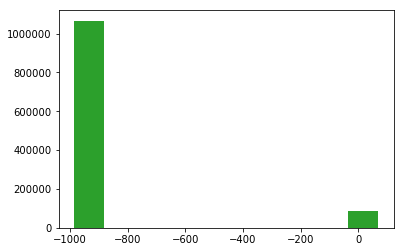

In [223]:
plt.hist(feat_matrix['age_diff'].dropna())
plt.show()

In [230]:
data.data_i_154.isnull().sum()

0

In [231]:
feat_matrix['know_recip_card_age'].value_counts(dropna=False)

1    1369615
Name: know_recip_card_age, dtype: int64

0.9822446453930485

In [236]:
feat_matrix['recip_card_age'].value_counts()

912321    1345297
19             95
14             87
18             86
74             80
62             80
75             76
21             75
42             74
17             74
51             73
34             73
24             72
28             72
82             72
16             72
20             72
90             72
36             71
64             71
41             71
85             71
58             71
50             70
239            70
12             70
61             70
69             69
56             69
33             68
           ...   
20077           1
9824            1
17004           1
14947           1
17003           1
10854           1
9830            1
9837            1
13932           1
9838            1
8820            1
7798            1
17020           1
10865           1
10870           1
14964           1
17018           1
11892           1
12918           1
10858           1
21089           1
27234           1
13930           1
11881           1
10857     

In [237]:
27234 / 365

74.61369863013698

In [239]:
data.cdf_s_124.max()

Timestamp('2017-11-24 00:00:00')

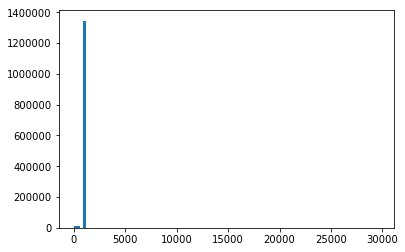

In [246]:
plt.hist(feat_matrix['recip_card_age'], bins = 100)
plt.show()

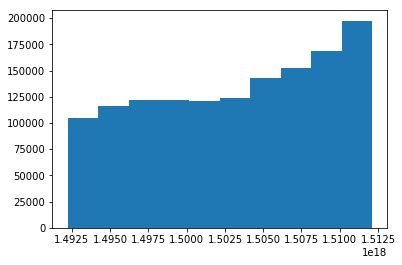

In [255]:
plt.hist(data.event_time.astype(int).dropna())
plt.show()

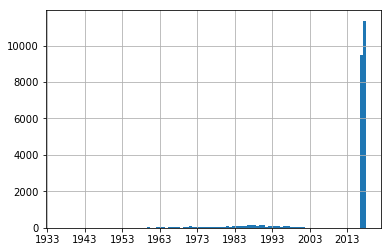

In [259]:
data.cdf_s_124.hist(bins = 100)
plt.show()

In [264]:
(data.cdf_s_124 < '2010-10-10').mean()

TypeError: invalid type comparison

In [265]:
(data.event_time - data.cdf_s_124).isnull()

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
           ... 
1369585    True
1369586    True
1369587    True
1369588    True
1369589    True
1369590    True
1369591    True
1369592    True
1369593    True
1369594    True
1369595    True
1369596    True
1369597    True
1369598    True
1369599    True
1369600    True
1369601    True
1369602    True
1369603    True
1369604    True
1369605    True
1369606    True
1369607    True
1369608    True
1369609    True
1369610    True
1369611    True
1369612    True
1369613    True
1369614    True
Length: 1369615, dtype: 

In [273]:
np.isnan((data.event_time - data.cdf_s_124)[0])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

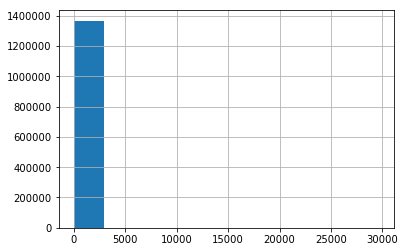

In [275]:
feat_matrix['recip_card_age'].hist()
plt.show()

In [317]:
# бинарный флаг определяющий наличие возраста получателя
# (полезен для линейных моделей,  менее для деревьев с учетом следующего признака)
feat_matrix['transfer_recip_age'] = [1 if x == 0 else 0 for x in data.cdf_s_294]
# разница возрастов получателей и отправителей, если отсутствует/неприменимо, то padding 500
feat_matrix['transfer_age_diff'] = feat_matrix.client_age - [int(x) if x != 0 else 1000 for x in data.cdf_s_294]
# перевод родственнику
feat_matrix['transfer_for_relative'] = [1 if x == 'ДА' else 0 for x in data.cdf_s_218] 
# сила связи отправителя и получателя
feat_matrix['transfer_know_recip_squared'] = [ x if x is not None else 0 for x in data.data_s_65]
# 'data_i_154' - ряд признаков, которые описывают устройство, с которого проводятся операции
feat_matrix['data_i_154'] = [ x if x is not None else -150 for x in data.data_i_154]
# 'cdf_s_124'- дата выдачи карты получателя
feat_matrix['know_recip_card_age'] = ~data.cdf_s_124.isnull().astype(int)
# в cdf_s_124 подмешана дата рождения, поэтому и max
feat_matrix['recip_card_age'] = [max(x.days, 1000) if type(x) is not pd.tslib.NaTType else 1000 
                                 for x in (data.event_time - data.cdf_s_124)]

# feat_matrix['cat_client_region'] = [x if x.isdigit() else 912321 for x in data.cdf_s_20]
feat_matrix['one_region'] = (data.cdf_s_20 == data.cdf_s_299).astype(int) # сравнение регионов

# там с провайдером какая-то фигня до этого была (использовалась левая переменная)
feat_matrix['ip_isp'] = data['ip_isp'].fillna(-1000000).astype(int)
tt.toc('Third')

Third 36312.678047 seconds.


In [283]:
data.columns

Index(['cdf_s_123', 'cdf_s_124', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
       'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126',
       'cdf_s_133', 'cdf_s_136', 'cdf_s_137', 'cdf_s_140', 'cdf_s_178_hashed',
       'cdf_s_19', 'cdf_s_20', 'cdf_s_218', 'cdf_s_294', 'cdf_s_299',
       'amount_original', 'channel_indicator_desc', 'custom_mark',
       'data_i_118', 'data_i_119', 'data_i_120', 'data_i_154', 'data_s_65',
       'event_description', 'event_id', 'event_time', 'ext_acct_number_hashed',
       'hardwareid', 'short_date', 'user_acct_number_hashed',
       'user_agent_string_hash', 'browser_plugins_hash', 'screen_hash',
       'user_id', 'ip_address', 'ip_country', 'ip_region', 'ip_city', 'ip_isp',
       'is_frad', 'is_fraud'],
      dtype='object')

In [ ]:
#ADD NEW FEATURES
feat_matrix['krp_pow2'] = (feat_matrix['know_recip_power']) ** 2
feat_matrix['log_amount'] = np.log(feat_matrix['amount'] + 1)

feat_matrix['client_region_len'] = data.cdf_s_20.apply(lambda x: len(str(x)))
feat_matrix['client_region'] = np.array([x if x.isdigit() else 999999 for x in data.cdf_s_20], dtype=float)
# там какая-то фигня была, переписал по смыслу
# 'cdf_s_136','cdf_s_137','cdf_s_140'- кумулятивные суммы операций за сутки в web, МП, web + МП 
feat_matrix['amnt2chnls'] = (data["amount_original"].fillna(0) / \
    (data["cdf_s_136"].fillna(0) + \
     data["cdf_s_136"].fillna(0) + \
     data["cdf_s_140"].fillna(0) + 1))
tt.toc('Fourth')

In [40]:
# поставил order_cols временно, чтобы сохранить такой же порядок как в оригинальном
order_cols = ['event_id', 'user_id', 'custom_mark', 'event_time', 'amount',
              'client_age', 'cat_new_ip', 'cat_new_prov', 'channel_op', 'op_type',
              'recip_age', 'age_diff', 'cumulative_sum_total', 'data_i_120',
              'relative', 'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
              'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
              'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
              'log_amount', 'ip_isp', 'amnt2chnls']
feat_matrix = feat_matrix[order_cols].copy()

First 0.839069 seconds.
Second 13.242162 seconds.


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)


Third 27.763675 seconds.
Fourth 28.399431 seconds.


NameError: name 'feat_mat' is not defined

---

In [14]:
type(data['ip_isp'][1])

str

In [10]:
data.loc[a] == 912321]

,cdf_s_123,cdf_s_124,cdf_s_127,cdf_s_135,cdf_s_130,cdf_s_129,cdf_s_134,cdf_s_128,cdf_s_138,cdf_s_126,...,user_acct_number_hashed,user_agent_string_hash,browser_plugins_hash,screen_hash,user_id,ip_address,ip_country,ip_region,ip_city,ip_isp


In [65]:
data['ip_isp'].value_counts()

7255229    234220
null       222162
4834278    170531
7255560    169346
7042071    137015
7320382     58893
7318189     36420
7255662     23472
132348      12599
7335751     12328
2523190     12322
6095671     11681
4986478      8846
1885336      7378
5140495      7310
7561994      6634
6884157      6083
4737439      4696
200327       4308
5720372      4105
171794       3734
3695467      3708
2798008      3681
2266255      3671
178935       3650
4776159      3633
220572       3344
4697132      3055
2186252      2749
5007587      2564
            ...  
7929783         1
7687368         1
4769282         1
5320427         1
5471182         1
4372884         1
7433021         1
5457963         1
7788886         1
5375360         1
2267955         1
2357392         1
2072980         1
218346          1
2359892         1
8360917         1
6516459         1
7154844         1
2383798         1
5129198         1
5178692         1
5332676         1
5714583         1
225356          1
2105276   

In [52]:
include_channels = ['Перевод частному лицу', 'Оплата услуг', 'Перевод между своими счетами и картами']

In [53]:
include_channels

['Перевод частному лицу',
 'Оплата услуг',
 'Перевод между своими счетами и картами']

In [54]:
start_date = 20171029
end_date = 20171128

In [55]:
feat_test = features_handler(
    chunk_names=[train_files[9]],
    calc_feat = calc_base_features,
    query=("event_description in {incl}  and short_date > {start} and short_date < {end}"
           .format(incl=include_channels, start=start_date, end=end_date)))

chunk_name is ../../data/raw_splits/train/chunk_9.fth
chunk_fnames is ../../data/raw_splits/train/chunk_9.fth
chunk_fnames type is <class 'str'>
chunk_fnames is ['../../data/raw_splits/train/chunk_9.fth']
../../data/raw_splits/train/chunk_9.fth


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)


In [59]:
feat_test.shape

(71785, 30)

In [60]:
feat_test.columns

Index(['event_id', 'user_id', 'custom_mark', 'event_time', 'amount',
       'client_age', 'cat_new_ip', 'cat_new_prov', 'channel_op', 'op_type',
       'recip_age', 'age_diff', 'cumulative_sum_total', 'data_i_120',
       'relative', 'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130',
       'cdf_s_129', 'cdf_s_134', 'data_i_154', 'cdf_s_133',
       'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2',
       'log_amount', 'ip_isp', 'amnt2chnls'],
      dtype='object')

In [ ]:
def get_data(chunk_name):
    #del feat_test
    feat_test = features_handler(
        chunk_names=[chunk_name],
        calc_feat = calc_base_features,
        # заменил > на >=
        query=("event_description in {incl}  and short_date >= {start} and short_date =< {end}"
               .format(incl=include_channels, start=start_date, end=end_date)))
    return feat_test

In [ ]:
%%time
# жрет вплоть более 70 гигов оперативки, осторожнее
with multiprocessing.Pool(processes=min(N_THREADS, FIRST_N)) as pool:
    results = pool.map(get_data, train_files)

In [ ]:
total_df = pd.DataFrame()
for i, df in enumerate(results):
    total_df = pd.concat([total_df, df])
    results[i] = 'bye'

In [ ]:
total_df['short_date'] = total_df.event_time.apply(lambda x: x.date())
total_df.rename(columns={"custom_mark": "label"}, inplace=True)
total_df['label'] = total_df.label.apply(lambda x: scr.cust_mark_to_class(x))

In [ ]:
total_df = total_df.query("label != -1")

In [ ]:
global_mean = np.mean(total_df['label'])

In [ ]:
n_uniques = np.apply_along_axis(lambda x: len(np.unique(x)), axis=0, arr=total_df)

In [ ]:
# total_df.to_csv("../data/coms_sep/train.csv")
total_df = pd.read_csv("../data/coms_sep/train.csv", index_col=0)

In [ ]:
def map_counter(data, field_name, target_name, alpha, global_mean=None):
    if global_mean is None:
        global_mean = data[target_name].mean()
    counters = data.groupby(field_name)[target_name].mean()
    n_counters = data.groupby(field_name)[target_name].count()
    out = ((data[field_name].map(counters) + global_mean * alpha)/ \
           (data[field_name].map(n_counters) + alpha))
    return out

In [ ]:
n_uniques

In [ ]:
total_df.columns

In [ ]:
for col in total_df.columns:
    col_name = total_df.columns[i]
    if col_name not in ['event_id', "user_id", "event_time", "label", "short_date"]:
        total_df[col] = map_counter(total_df, col, 'label',
                                    alpha=1000,
                                    global_mean=global_mean)

In [ ]:
#total_df.to_csv("../data/coms_sep/train_cntrs.csv")
#total_df = pd.read_csv("../data/coms_sep/train_cntrs.csv", index_col=0)

In [ ]:
total_df.label.value_counts()